In [1]:
! pip install transformers
! pip install torch
! pip install Basemap
! pip install basemap-data-hires

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!git clone -b predict https://github.com/K4TEL/geo-twitter.git

fatal: destination path 'geo-twitter' already exists and is not an empty directory.


In [4]:
! pip install -r /content/geo-twitter/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import sys
sys.path.append('/content/geo-twitter')

from text_result import *

In [6]:
hub_model = 'k4tel/geo-bert-multilingual'
base_model = "bert-base-multilingual-cased"

In [7]:
# load HF model
def load(hub_model, base_model, cov="spher"):
    model_wrapper = BERTregModel(5, cov, base_model, hub_model)
    tokenizer = BertTokenizer.from_pretrained(hub_model)
    return model_wrapper, tokenizer

In [8]:
# use HF model to predict location for text
def predict(model_wrapper, tokenizer, text):
    result = ResultManager(text, "NON-GEO", torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"), model_wrapper, hub_model)
    model = model_wrapper.model

    inputs = tokenizer(text, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    print(f"RESULT\tPost-processing raw model outputs: {outputs}")
    result.raw_to_params(outputs)

    ind = np.argwhere(np.round(result.weights[0, :] * 100, 2) > 0)
    significant = result.means[0, ind].reshape(-1, 2)
    weights = result.weights[0, ind].flatten()

    sig_weights = np.round(weights * 100, 2)
    sig_weights = sig_weights[sig_weights > 0]

    print(f"RESULT\t{len(sig_weights)} significant prediction outcome(s):")

    for i in range(len(sig_weights)):
        point = f"lon: {'  lat: '.join(map(str, significant[i]))}"
        print(f"\tOut {i + 1}\t{sig_weights[i]}%\t-\t{point}")

    return result

In [9]:
text = "CIA and FBI can track anyone, and you willingly give the data away"

In [10]:
model, tokenizer = load(hub_model, base_model)

MODEL	Initializing BERT Regression model for 5 outcome(s)
MODEL	Text features:	NON-GEO + GEO-ONLY
MODEL	Coordinates:	10
MODEL	Weights:	5
MODEL	Covariances:	5	matrix type:	spher
MODEL	Original model to load:	bert-base-multilingual-cased
MODEL	Key feature 	NON-GEO outputs:	20
MODEL	Minor feature	GEO-ONLY outputs:	3
LOAD	Loading HF model from k4tel/geo-bert-multilingual


In [11]:
result = predict(model, tokenizer, text)

RESULT	Post-processing raw model outputs: tensor([[-5.9559e+01,  2.5594e+01, -7.7809e+01,  3.6757e+01, -7.8424e+01,
          3.5901e+01,  1.9619e+01,  3.1906e+01, -7.3438e+01,  7.6303e+00,
         -1.5058e+01,  4.5960e+00,  3.5896e+00, -1.5626e+01, -1.5860e+01,
         -9.0520e-02,  5.2277e+01, -5.4709e+00,  1.5287e+02, -1.0392e+02]])
RESULT	2 significant prediction outcome(s):
	Out 1	73.2300033569336%	-	lon: -77.80862  lat: 36.75654
	Out 2	26.770000457763672%	-	lon: -78.42436  lat: 35.90061


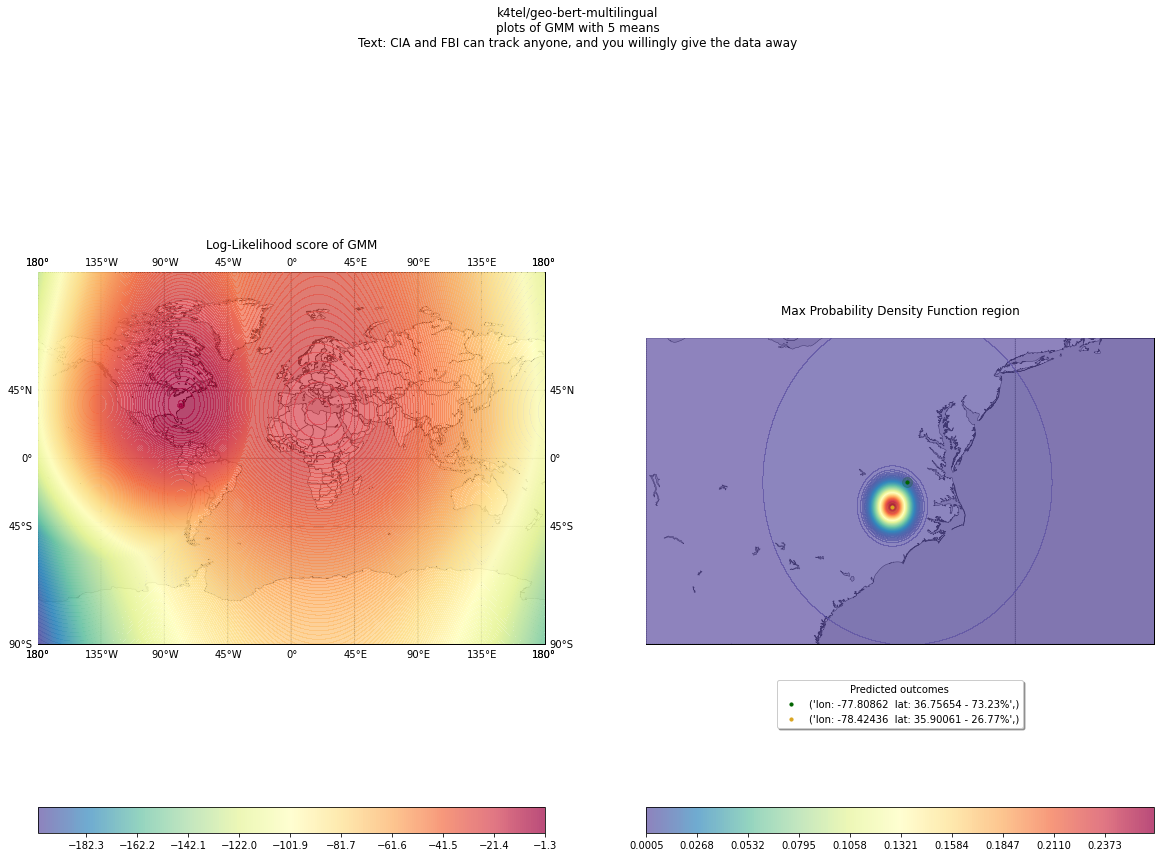

In [12]:
visual = ResultVisuals(result)
visual.text_map_result()